# Film Recommender System

![netflix cover](https://image.slidesharecdn.com/qcon-xavier-131118142118-phpapp01/95/qcon-sf-2013-machine-learning-recommender-systems-netflix-scale-5-638.jpg?cb=1384784551)

## Methods Used

Two most common types of recommender systems like the one´s used in Netflix and Spotify are **Content-Based** and **Collaborative Filtering (CF)**. 

* Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the "wisdom of the crowd" to recommend items. 
* Content-based recommender systems focus on the attributes of the items and give you recommendations based on the similarity between them.

## Collaborative Filtering

In general, Collaborative filtering (CF) is more commonly used than content-based systems because it usually gives better results and is relatively easy to understand (from an overall implementation perspective). The algorithm has the ability to do feature learning on its own, which means that it can start to learn for itself what features to use. 

CF can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. 

In this tutorial, we will implement Model-Based CF by using singular value decomposition (SVD) and Memory-Based CF by computing cosine similarity.


## The Data

I´ll be using the famous MovieLens dataset, which is one of the most common datasets used when implementing and testing recommender engines. It contains 100k movie ratings from 943 users and a selection of 1682 movies.

You can download the dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

## Needed Libraries

In [1]:
#Data Manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

#Setting Train and Test Data
from sklearn.model_selection import train_test_split

#For Memory-Based Collaborative Filtering
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt

# For Model-based Collaborative Filtering
import scipy.sparse as sp
from scipy.sparse.linalg import svds

I´ve saved the dataset in the **u.data** file, which contains the full dataset. You can read a brief description of the dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).

In [2]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
movies = pd.read_csv('u.data', sep='\t', names=column_names)

Let's take a overview look at the data.

In [3]:
movies.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


We only have the item_id, not the movie name. We can use the Movie_ID_Titles csv file (avaiable in the link quoted above) to grab the movie names and merge it with this dataframe:

In [4]:
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [5]:
movies = pd.merge(movies,movie_titles,on='item_id')
movies.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


Now let's take a quick look at the number of unique users and movies.

In [6]:
n_users = movies.user_id.nunique()
n_items = movies.item_id.nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+str(n_items))

Num. of Users: 944
Num of Movies: 1682


## EDA

In [7]:
#Five Higher ratings by order
movies.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [8]:
#Five most rated movies by order
movies.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [9]:
ratings = pd.DataFrame(movies.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(movies.groupby('title')['rating'].count())

ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


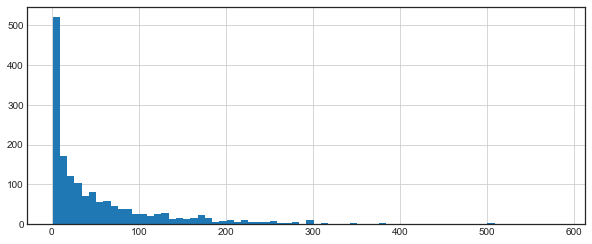

In [10]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

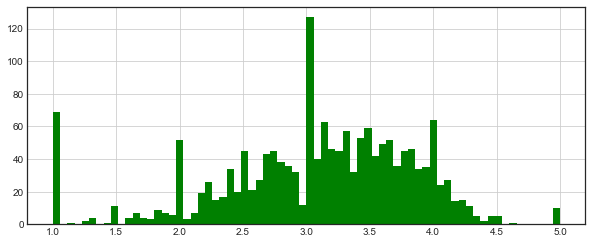

In [11]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70,
                      color='g')

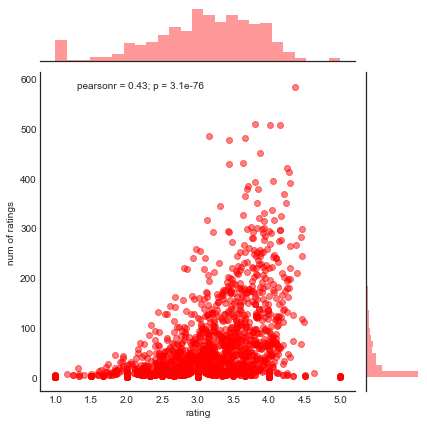

In [12]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5, color='red')

## Train Test Split

Recommendation Systems by their very nature are very difficult to evaluate, but we´ll try. In order to do this, we'll split our data into two sets. However, we won't do the classic X_train,X_test,y_train,y_test split. Instead we can actually just segement the data into two sets of data:

In [13]:
train_data, test_data = train_test_split(movies, test_size=0.3)

## Memory-Based Collaborative Filtering

Memory-Based Collaborative Filtering approaches can be divided into two main sections: **user-item filtering** and **item-item filtering**. 

A *user-item filtering* will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. 

In contrast, *item-item filtering* will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations. 

* *Item-Item Collaborative Filtering*: “Users who liked this item also liked …”
* *User-Item Collaborative Filtering*: “Users who are similar to you also liked …”

In both cases, we must create a user-item matrix which built from the entire dataset.

Since we have split the data into testing and training we will need to create two ``[943 x 1682]`` matrices (all users by all movies). 

The training matrix contains 75% of the ratings and the testing matrix contains 25% of the ratings. 

Example of user-item matrix:
<img class="aligncenter size-thumbnail img-responsive" src="http://s33.postimg.org/ay0ty90fj/BLOG_CCA_8.png" alt="blog8"/>

After we have built the user-item matrix we calculate the similarity and create a similarity matrix. 

The similarity values between items in *Item-Item Collaborative Filtering* are measured by observing all the users who have rated both items.  

<img class="aligncenter size-thumbnail img-responsive" style="max-width:100%; width: 50%; max-width: none" src="http://s33.postimg.org/i522ma83z/BLOG_CCA_10.png"/>

A distance metric commonly used in recommender systems is *cosine similarity*, where the ratings are seen as vectors in ``n``-dimensional space and the similarity is calculated based on the angle between these vectors. 
Cosine similiarity for users *a* and *m* can be calculated using the formula below, where you take dot product of  the user vector *$u_k$* and the user vector *$u_a$* and divide it by multiplication of the Euclidean lengths of the vectors.
<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(u_k,u_a)=\frac{u_k&space;\cdot&space;u_a&space;}{&space;\left&space;\|&space;u_k&space;\right&space;\|&space;\left&space;\|&space;u_a&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{k,m}x_{a,m}}{\sqrt{\sum&space;x_{k,m}^2\sum&space;x_{a,m}^2}}"/>

To calculate similarity between items *m* and *b* you use the formula:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(i_m,i_b)=\frac{i_m&space;\cdot&space;i_b&space;}{&space;\left&space;\|&space;i_m&space;\right&space;\|&space;\left&space;\|&space;i_b&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{a,m}x_{a,b}}{\sqrt{\sum&space;x_{a,m}^2\sum&space;x_{a,b}^2}}
"/>

Our first step will be to create the user-item matrix. Since we have both testing and training data you need to create two matrices.  


In [14]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

We can use the [pairwise_distances](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html) function from sklearn to calculate the cosine similarity. Note, the output will range from 0 to 1 since the ratings are all positive.

In [15]:
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

Next step is to make predictions. We have already created similarity matrices: `user_similarity` and `item_similarity` and therefore we can make a prediction by applying following formula for user-based CF:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>

We can look at the similarity between users *k* and *a* as weights that are multiplied by the ratings of a similar user *a* (corrected for the average rating of that user). We´ll need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that you are trying to predict. 

The idea here is that some users may tend always to give high or low ratings to all movies. The relative difference in the ratings that these users give is more important than the absolute values. To give an example: suppose, user *k* gives 4 stars to his favourite movies and 3 stars to all other good movies. Suppose now that another user *t* rates movies that he/she likes with 5 stars, and the movies he/she fell asleep over with 3 stars. These two users could have a very similar taste but treat the rating system differently. 

When making a prediction for item-based CF you don't need to correct for users average rating since query user itself is used to do predictions.

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\frac{\sum\limits_{i_b}&space;sim_i(i_m,&space;i_b)&space;(x_{k,b})&space;}{\sum\limits_{i_b}|sim_i(i_m,&space;i_b)|}"/>

In [16]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [17]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

### Evaluation
There are many evaluation metrics but one of the most popular metric used to evaluate accuracy of predicted ratings is *Root Mean Squared Error (RMSE)*. 
<img src="https://latex.codecogs.com/gif.latex?RMSE&space;=\sqrt{\frac{1}{N}&space;\sum&space;(x_i&space;-\hat{x_i})^2}" title="RMSE =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}" />

We can use the [mean_square_error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) (MSE) function from `sklearn`, where the RMSE is just the square root of MSE. To read more about different evaluation metrics you can take a look at [this article](http://research.microsoft.com/pubs/115396/EvaluationMetrics.TR.pdf). 

Since you only want to consider predicted ratings that are in the test dataset, you filter out all other elements in the prediction matrix with `prediction[ground_truth.nonzero()]`. 

In [18]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [19]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.1634721455684893
Item-based CF RMSE: 3.4690295615253675


Memory-based algorithms are easy to implement and produce reasonable prediction quality. 
The drawback of memory-based CF is that it doesn't scale to real-world scenarios and doesn't address the well-known cold-start problem, that is when new user or new item enters the system. Model-based CF methods are scalable and can deal with higher sparsity level than memory-based models, but also suffer when new users or items that don't have any ratings enter the system.

# Model-based Collaborative Filtering

Model-based Collaborative Filtering is based on **matrix factorization (MF)** which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF. The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. 

When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization you can restructure the  user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

Let's calculate the sparsity level of MovieLens dataset:

In [20]:
sparsity=round(1.0-len(movies)/float(n_users*n_items),3)
print('The sparsity level of MovieLens100K is ' +  str(sparsity*100) + '%')

The sparsity level of MovieLens100K is 93.7%


To give an example of the learned latent preferences of the users and items: let's say for the MovieLens dataset you have the following information: _(user id, age, location, gender, movie id, director, actor, language, year, rating)_. By applying matrix factorization the model learns that important user features are _age group (under 10, 10-18, 18-30, 30-90)_, _location_ and _gender_, and for movie features it learns that _decade_, _director_ and _actor_ are most important. Now if you look into the information you have stored, there is no such feature as the _decade_, but the model can learn on its own. The important aspect is that the CF model only uses data (user_id, movie_id, rating) to learn the latent features. If there is little data available model-based CF model will predict poorly, since it will be more difficult to learn the latent features. 

Models that use both ratings and content features are called **Hybrid Recommender Systems** where both Collaborative Filtering and Content-based Models are combined. Hybrid recommender systems usually show higher accuracy than Collaborative Filtering or Content-based Models on their own: they are capable to address the cold-start problem better since if you don't have any ratings for a user or an item you could use the metadata from the user or item to make a prediction. 

### SVD
A well-known matrix factorization method is **Singular value decomposition (SVD)**. Collaborative Filtering can be formulated by approximating a matrix `X` by using singular value decomposition. The winning team at the Netflix Prize competition used SVD matrix factorization models to produce product recommendations, for more information I recommend to read articles: [Netflix Recommendations: Beyond the 5 stars](http://techblog.netflix.com/2012/04/netflix-recommendations-beyond-5-stars.html) and [Netflix Prize and SVD](http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf).
The general equation can be expressed as follows:
<img src="https://latex.codecogs.com/gif.latex?X=USV^T" title="X=USV^T" />


Given `m x n` matrix `X`:
* *`U`* is an *`(m x r)`* orthogonal matrix
* *`S`* is an *`(r x r)`* diagonal matrix with non-negative real numbers on the diagonal
* *V^T* is an *`(r x n)`* orthogonal matrix

Elements on the diagnoal in `S` are known as *singular values of `X`*. 


Matrix *`X`* can be factorized to *`U`*, *`S`* and *`V`*. The *`U`* matrix represents the feature vectors corresponding to the users in the hidden feature space and the *`V`* matrix represents the feature vectors corresponding to the items in the hidden feature space.
<img class="aligncenter size-thumbnail img-responsive" style="max-width:100%; width: 50%; max-width: none" src="http://s33.postimg.org/kwgsb5g1b/BLOG_CCA_5.png"/>

Now we can make a prediction by taking dot product of *`U`*, *`S`* and *`V^T`*.

<img class="aligncenter size-thumbnail img-responsive" style="max-width:100%; width: 50%; max-width: none" src="http://s33.postimg.org/ch9lcm6pb/BLOG_CCA_4.png"/>

In [21]:
#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE: 2.798750843212325


Carelessly addressing only the relatively few known entries is highly prone to overfitting. SVD can be very slow and computationally expensive. Looking up while writting this Git, I noticed that lots of [recent work](https://github.com/rasbt/python-machine-learning-book/blob/master/faq/closed-form-vs-gd.md) minimizes the squared error by applying alternating least square or stochastic gradient descent and uses regularization terms to prevent overfitting.

I´m still studying how to alternate least square and stochastic gradient descent methods for CF and I plan to test it in the near future.

Conclusion:

* I have covered how to implement simple **Collaborative Filtering** methods, both memory-based CF and model-based CF.
* **Memory-based models** are based on similarity between items or users, where we use cosine-similarity.
* **Model-based CF** is based on matrix factorization where we use SVD to factorize the matrix.
* We found out that Building recommender systems that perform well in cold-start scenarios (where little data is available on new users and items) is bit of a challenge. The standard collaborative filtering method have performed poorly is such settings. 